# Lab 4

This notebook is based on on Chapter 2 of *Humanities Data Analysis: Case Studies with Python* by Folgert Karsdorp, Mike Kestemont, and Allen Riddell (Princeton University Press 2021). Some sections are quoted verbatim, while others are revised by KAK for ENC HN class. The dataset used in the exercises was released together with the book and can be found here: https://doi.org/10.5281/zenodo.891264.

Today, in addition to testing some of the concepts introduced during the lecture we will reproduce a small research project, namely we will produce and analyse the interaction network of characters in some of the most famous of Shakespeare's plays.


The data sources we will be working with today is in XML format. 
If you don't remember what XML is or how to process XMLs with Python, read the "XML" section of Chapter 2, available here https://www.humanitiesdataanalysis.org/getting-data/notebook.html#xml, before starting to work on this notebook. 




## 1. Introduction: Social Network of Hamlet by Karsdorp et al. 


The starting question for today is: 
How to identify and visualize the "social network" of characters in *Hamlet*?

The idea of visualizing the character network of *Hamlet* goes back to {cite:t}`moretti:2011`. Moretti's *Hamlet* network is not reproducible and depends on ad hoc determinations of whether or not characters interacted. Karsdorp, Kestemont and Rieddel's goal was to identify and visualize a character network in a reproducible manner!


_Verbatim extracts below:_ 


> The relationship between fictional characters in literary works can be conceptualized as <span class="index">social network</span>s. In recent years, the computational analysis of such fictional social networks has steadily gained popularity. Network analysis can contribute to the study of literary fiction by formally mapping character relations in individual works. More interestingly, however, is when network analysis is applied to larger collections of works, revealing the abstract and general patterns and structure of character networks.

> In the networks we will extract from Shakespeare's plays, nodes are represented by speakers. What determines a connection (i.e., an edge) between two speakers is less straightforward and strongly dependent on the sort of relationship one wishes to capture. Here, we construct edges between two speakers if they are "in interaction with each other". Two speakers $A$ and $B$ interact, we claim, if an utterance of $A$ is preceded or followed by an utterance of $B$.

> Our approach here diverges from {cite:t}`moretti:2011`'s own approach in which he manually extracted these interactions, whereas we follow a fully automated approach. For Moretti, "two characters are linked if some words have passed between them: an interaction, is a speech act" {cite:p}`moretti:2011`.

> Furthermore, in order to track the frequency of character interactions, each of the edges in our approach will hold a count representing the number of times two speakers have interacted. This number thus becomes a so-called attribute or property of the edge that has to be explicitly stored. The final result can then be described as a <span class="index">network</span> in which speakers are represented as nodes, and interactions between speakers are represented as weighted edges. Having defined the type of social network we aim to construct, the real challenge we face is to extract such networks from Shakespeare's plays in a data format that can be easily exchanged.

> Fortunately, the Folger Digital Texts of Shakespeare provides annotations for
speaker turns, which give a rich information source that can be useful in the construction
of the character network. Now that we are able to parse XML, we can extract speaker turns
from the data files: the speaker turns and the entailing text uttered by a speaker are enclosed within `sp` tags. The ID of its corresponding speaker is stored in the `who` attribute. Consider the following fragment:

``` XML
<sp xml:id="sp-0200" who="#Rosalind_AYL">
  <speaker xml:id="spk-0200">
    <w xml:id="w0035750">ROSALIND</w>
  </speaker>
  <ab xml:id="ab-0200">
    <w xml:id="w0035760" n="1.2.30">What</w>
    <c xml:id="c0035770" n="1.2.30"> </c>
    <w xml:id="w0035780" n="1.2.30">shall</w>
    <c xml:id="c0035790" n="1.2.30"> </c>
    <w xml:id="w0035800" n="1.2.30">be</w>
    <c xml:id="c0035810" n="1.2.30"> </c>
    <w xml:id="w0035820" n="1.2.30">our</w>
    <c xml:id="c0035830" n="1.2.30"> </c>
    <w xml:id="w0035840" n="1.2.30">sport</w>
    <pc xml:id="p0035850" n="1.2.30">,</pc>
    <c xml:id="c0035860" n="1.2.30"> </c>
    <w xml:id="w0035870" n="1.2.30">then</w>
    <pc xml:id="p0035880" n="1.2.30">?</pc>
  </ab>
</sp>
```

> With this information about speaker turns, implementing a function to extract character interaction networks becomes trivial. Consider the function `character_network()` below, which takes as argument a `lxml.ElementTree` object and returns a character network represented as a <span class="index">`networkx.Graph`</span> object:

For this to work we need to import etree from `lxml` (https://pypi.org/project/lxml/) in addtion to our usual packages: 

In [1]:
! pip install lxml

In [4]:
import lxml.etree
import matplotlib.pyplot as plt
import networkx as nx

Then we define the function: 

In [5]:
# First we need to map the namespaces used in the XML document. Folger texts are encoded in TEI, so we only need one: 
NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}


def character_network(tree): # function by Karsdorp et al., HDA (2021)
    """Construct a character interaction network.

    Construct a character interaction network for Shakespeare texts in
    the Folger Digital Texts collection. Character interaction networks
    are constructed on the basis of successive speaker turns in the texts,
    and edges between speakers are created when their utterances follow
    one another.

    Arguments:
        tree: An lxml.ElementTree instance representing one of the XML
            files in the Folger Shakespeare collection.

    Returns:
        A character interaction network represented as a weighted,
        undirected NetworkX Graph.

    """
    G = nx.Graph() # Create an empty Graph, which we will populate as we loop though the XML file. 
    
    # extract a list of speaker turns for each scene in a play
    for scene in tree.iterfind('.//tei:div2[@type="scene"]', NSMAP):
        speakers = scene.findall('.//tei:sp', NSMAP)
        # iterate over the sequence of speaker turns...
        for i in range(len(speakers) - 1):
            # ... and extract pairs of adjacent speakers
            try:
                speaker_i = speakers[i].attrib['who'].split('_')[0].replace('#', '')
                speaker_j = speakers[i + 1].attrib['who'].split('_')[0].replace('#', '')
                # if the interaction between two speakers has already
                # been attested, update their interaction count
                if G.has_edge(speaker_i, speaker_j):
                    G[speaker_i][speaker_j]['weight'] += 1
                # else add an edge between speaker i and j to the graph
                else:
                    G.add_edge(speaker_i, speaker_j, weight=1)
            except KeyError:
                continue
    return G

Note that this code employs search expressions in the <span class="index">XPath</span> syntax. The expression we pass to `tree.iterfind()`, for instance, uses a so-called predicate (`[@type="scene"]`) to select all `div2` elements that have a `"type"` attribute with a value of `"scene"`. In the returned part of the XML tree, we then only select the speaker elements (`sp`) and parse their `who` attribute, to help us reconstruct, or at least approximate, the conversations which are going on in this part of the play.

Let's test the function on one of Shakespeare's plays, <span class="index">*Hamlet*</span>:

In [6]:
tree = lxml.etree.parse('data/folger/xml/Ham.xml')
G = character_network(tree.getroot())

The extracted social network consists of 38 nodes (i.e. unique speakers) and 73 edges (i.e., unique <span class="index">speaker interactions</span>):

In [7]:
print(f"N nodes = {G.number_of_nodes()}, N edges = {G.number_of_edges()}")

N nodes = 38, N edges = 73


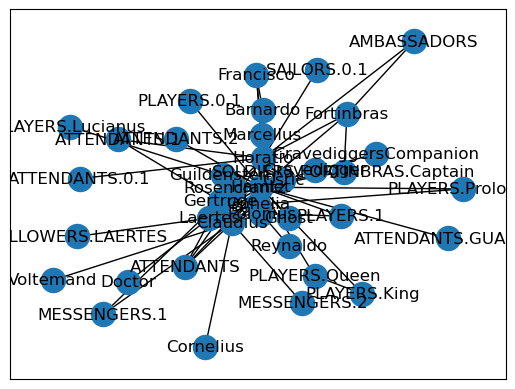

In [8]:
nx.draw_networkx(G)

As usually, this doesn't look so good, right? 
Therefore, it's the right time to introduce some layout algorithms included in NetworkX. 
Among the most commonly used ones, which can be also found in other usual network visualisation softwares, such as Gephi, there are:
- `fruchterman_reingold_layout` or simply `spring_layout`, which position nodes using Fruchterman-Reingold force-directed algorithm (See: Fruchterman, T. M. J., & Reingold, E. M. (1991). Graph Drawing by Force-Directed Placement. Software: Practice and Experience, 21(11).). "The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the positions are close to an equilibrium" (https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout).
- `forceatlas2_layout`, which positions nodes using the ForceAtlas2 force-directed layout algorithm (See: Jacomy, M., Venturini, T., Heymann, S., Bastian, M.,  ForceAtlas2, a Continuous Graph Layout Algorithm for Handy Network Visualization Designed for the Gephi Software, DOI: 10.1371/journal.pone.0098679). 
"The algorithm uses physical simulation to minimize the energy of the system, resulting in a more readable layout." (https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.forceatlas2_layout.html#networkx.drawing.layout.forceatlas2_layout).


Let's try them out:

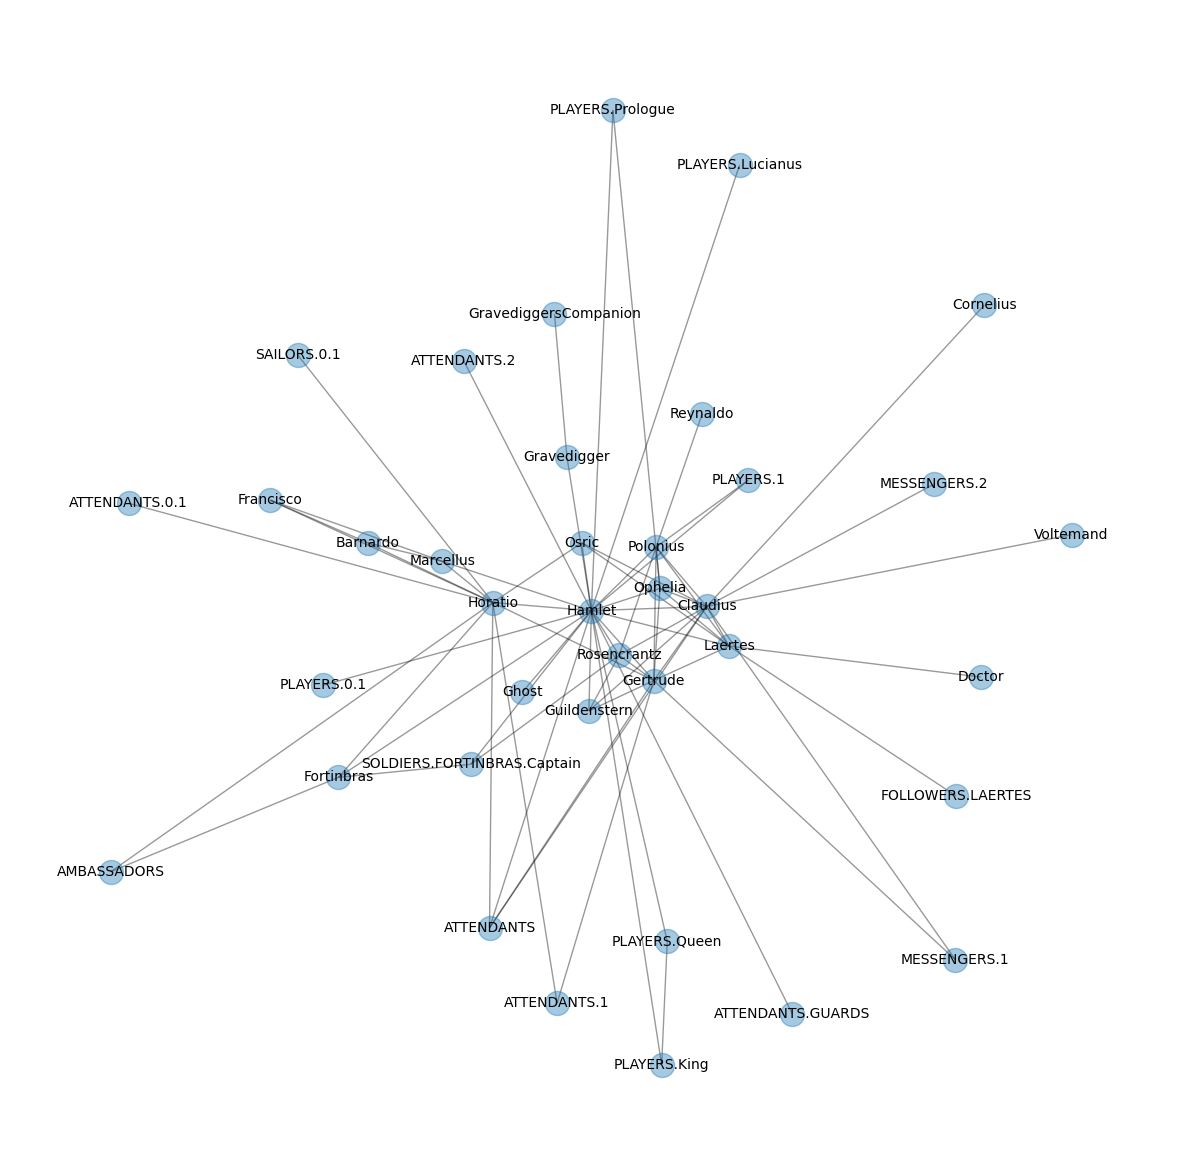

In [9]:
fig = plt.figure(figsize=(15, 15))
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.4) #alpha for transparency of edges, set to 0.4
nx.draw_networkx_nodes(G, pos, alpha=0.4) #alpha for transparency of nodes, set to 0.4
nx.draw_networkx_labels(G, pos, font_size=10) #font_size to adjust the size of the font, set to 10 pt 
plt.axis('off');

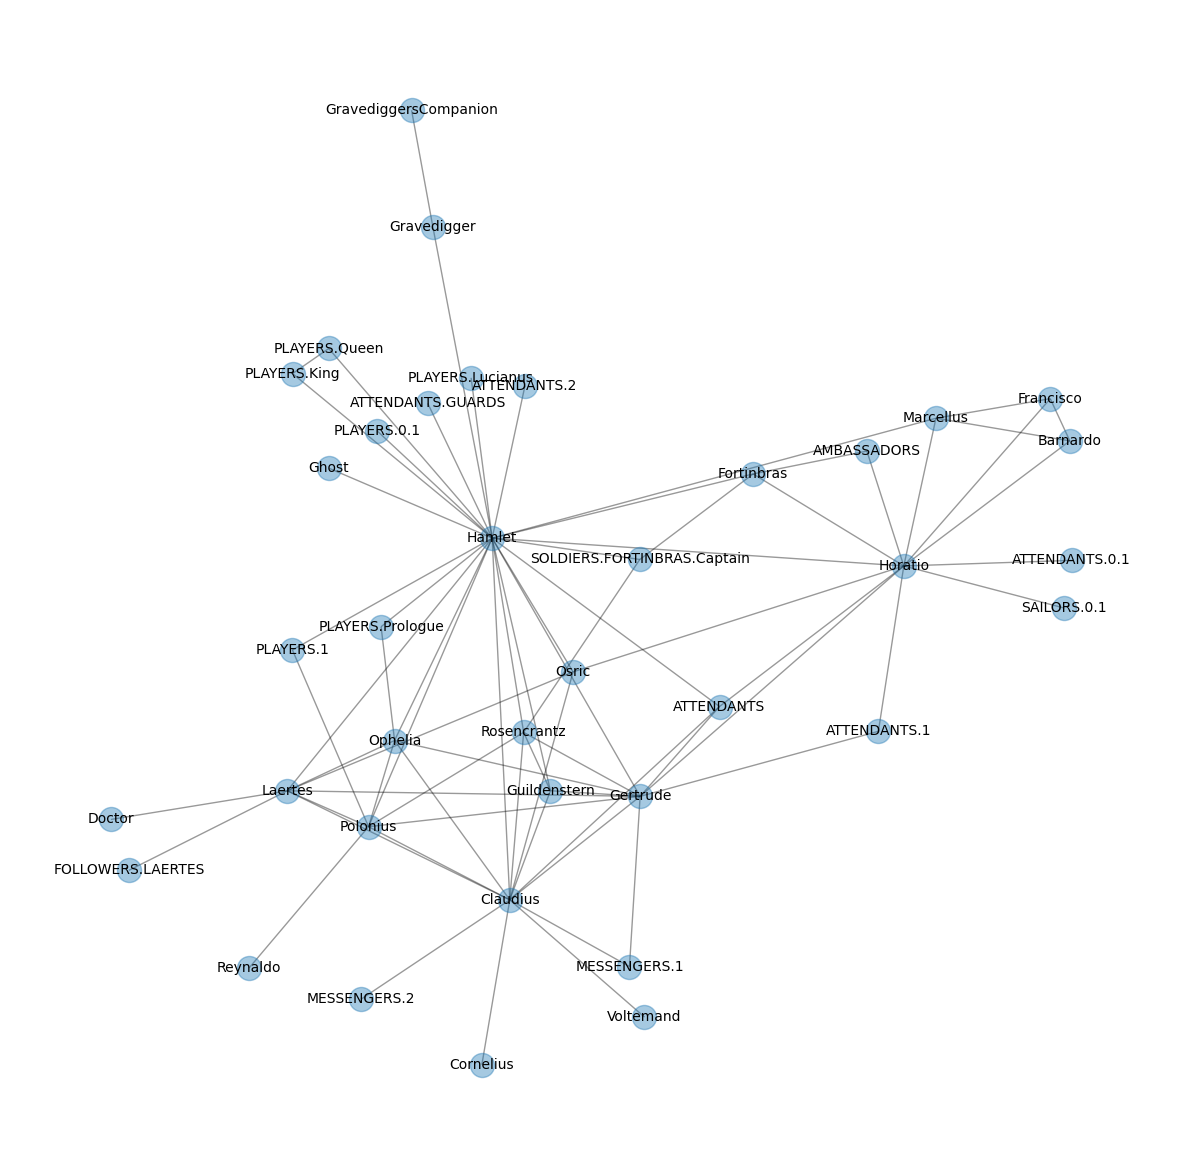

In [10]:
fig = plt.figure(figsize=(15, 15))
pos = nx.forceatlas2_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.4) #alpha for transparency of edges, set to 0.4
nx.draw_networkx_nodes(G, pos, alpha=0.4) #alpha for transparency of nodes, set to 0.4
nx.draw_networkx_labels(G, pos, font_size=10) #font_size to adjust the size of the font, set to 10 pt 
plt.axis('off');

Before going any further, let's save our network in some network-analysis-friendly format, for example Pajek NET: 

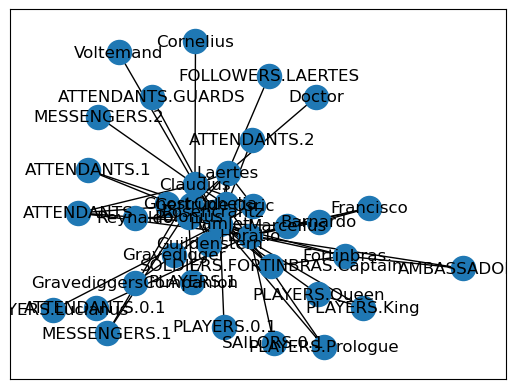

In [11]:
nx.write_pajek(G, "hamlet.net", encoding='UTF-8')
# Let's check whether it has been saved properly:
Hamlet = nx.read_pajek("hamlet.net", encoding='UTF-8')
nx.draw_networkx(Hamlet)

# 2. Measuring the importance of characters
Now when we have our Hamlet network safely stored on our machines, we can explore some of the properties of this network. We will focus mainly on the importance of the nodes. 

Today, during the lecture, we learned about some new measures, including different types of centralities and ways of identifying hubs in the network. 
We have learned: 
- how to mathematically identify hubs, as nodes with degree much higher than network's average.  
- how calculate and interpret different centrality measures (degree centrality, closeness centrality, and betweenness centrality),
- how to evaluate the structure of the network in term of its robustness and assortativity.

Now let's look how to calculate these with NetworkX.

To find the hubs, we might want to know what's the average degree in the network.


In [20]:
average_degree = 2 * G.number_of_edges() / G.number_of_nodes() 
print("The average degree:", average_degree)

nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
print(nodes_sorted_by_degree)


The average degree: 3.8421052631578947
['Hamlet', 'Claudius', 'Horatio', 'Gertrude', 'Laertes', 'Polonius', 'Ophelia', 'Rosencrantz', 'Marcellus', 'Guildenstern', 'Fortinbras', 'ATTENDANTS', 'Osric', 'Barnardo', 'Francisco', 'SOLDIERS.FORTINBRAS.Captain', 'PLAYERS.1', 'PLAYERS.Prologue', 'PLAYERS.King', 'PLAYERS.Queen', 'ATTENDANTS.1', 'MESSENGERS.1', 'Gravedigger', 'AMBASSADORS', 'Cornelius', 'Ghost', 'Reynaldo', 'Voltemand', 'PLAYERS.0.1', 'PLAYERS.Lucianus', 'ATTENDANTS.GUARDS', 'FOLLOWERS.LAERTES', 'ATTENDANTS.0.1', 'SAILORS.0.1', 'MESSENGERS.2', 'GravediggersCompanion', 'Doctor', 'ATTENDANTS.2']


In [ ]:
highest_degree_node = max(G.nodes, key=G.degree)
print("Highest degree node is:", highest_degree_node)
print("The degree of the highest degree node is:", G.degree(highest_degree_node))

Highest degree node is: Hamlet
The degree of the highest degree node is: 23


Is this the end of the story? You should remember from Lab 2 that it isn't. 

`max()` will only return one node even if multiple nodes share the highest value — it just picks the first one it encounters.

We have to look for multiple nodes, not just one: 

In [18]:
highDegNodes = []
for node in G.nodes: 
    if G.degree(node) >= average_degree:
        highDegNodes.append(node)

print("All nodes with degree higher than average are:", highDegNodes)

All nodes with degree higher than average are: ['Horatio', 'Marcellus', 'Claudius', 'Laertes', 'Polonius', 'Hamlet', 'Gertrude', 'Ophelia', 'Rosencrantz', 'Guildenstern', 'Fortinbras', 'ATTENDANTS', 'Osric']


In [21]:
# To calculate degree centrality, we use: 
degree_centr = nx.degree_centrality(G)
print("Normalised Degree Centrality of all nodes:", degree_centr)


highest_centr_value = max(degree_centr.values())
highest_centr_node = max(G.nodes, key=degree_centr.get)
highest_centr_nodes = [node for node, value in degree_centr.items() if value == highest_centr_value]



print("The node with the highest degree centrality value is:", highest_centr_node)
print("The normalised degree of the node is:", degree_centr[highest_centr_node])
print("The heighest value is:", highest_centr_value)
print("The nodes with highest centrality are:", highest_centr_nodes, "with value", highest_centr_value)




Normalised Degree Centrality of all nodes: {'Barnardo': 0.08108108108108109, 'Francisco': 0.08108108108108109, 'Horatio': 0.32432432432432434, 'Marcellus': 0.10810810810810811, 'Claudius': 0.35135135135135137, 'Cornelius': 0.02702702702702703, 'Laertes': 0.21621621621621623, 'Polonius': 0.21621621621621623, 'Hamlet': 0.6216216216216217, 'Gertrude': 0.2972972972972973, 'Ophelia': 0.16216216216216217, 'Ghost': 0.02702702702702703, 'Reynaldo': 0.02702702702702703, 'Rosencrantz': 0.16216216216216217, 'Guildenstern': 0.10810810810810811, 'Voltemand': 0.02702702702702703, 'PLAYERS.1': 0.05405405405405406, 'PLAYERS.0.1': 0.02702702702702703, 'PLAYERS.Prologue': 0.05405405405405406, 'PLAYERS.King': 0.05405405405405406, 'PLAYERS.Queen': 0.05405405405405406, 'PLAYERS.Lucianus': 0.02702702702702703, 'ATTENDANTS.GUARDS': 0.02702702702702703, 'Fortinbras': 0.10810810810810811, 'SOLDIERS.FORTINBRAS.Captain': 0.08108108108108109, 'ATTENDANTS.1': 0.05405405405405406, 'MESSENGERS.1': 0.0540540540540540

In [ ]:
# To calculate betweenness centrality, we use: 
betweenness = nx.centrality.betweenness_centrality(G)
print("Betweenness of all nodes:", betweenness)

# To calaculate closeness, we use:
closeness_centr = nx.centrality.closeness_centrality(G)
print(closeness_centr)

Betweenness of all nodes: {'Barnardo': 0.0, 'Francisco': 0.0, 'Horatio': 0.22662662662662664, 'Marcellus': 0.028678678678678682, 'Claudius': 0.1888138138138138, 'Cornelius': 0.0, 'Laertes': 0.10848348348348348, 'Polonius': 0.06431431431431432, 'Hamlet': 0.612937937937938, 'Gertrude': 0.10095095095095093, 'Ophelia': 0.008758758758758757, 'Ghost': 0.0, 'Reynaldo': 0.0, 'Rosencrantz': 0.007882882882882882, 'Guildenstern': 0.0, 'Voltemand': 0.0, 'PLAYERS.1': 0.0, 'PLAYERS.0.1': 0.0, 'PLAYERS.Prologue': 0.0, 'PLAYERS.King': 0.0, 'PLAYERS.Queen': 0.0, 'PLAYERS.Lucianus': 0.0, 'ATTENDANTS.GUARDS': 0.0, 'Fortinbras': 0.01921921921921922, 'SOLDIERS.FORTINBRAS.Captain': 0.0011261261261261261, 'ATTENDANTS.1': 0.0, 'MESSENGERS.1': 0.0, 'FOLLOWERS.LAERTES': 0.0, 'ATTENDANTS.0.1': 0.0, 'SAILORS.0.1': 0.0, 'MESSENGERS.2': 0.0, 'Gravedigger': 0.05405405405405406, 'GravediggersCompanion': 0.0, 'Doctor': 0.0, 'ATTENDANTS': 0.008108108108108107, 'Osric': 0.01599099099099099, 'ATTENDANTS.2': 0.0, 'AMBASSA

## Exercise 1

Before you move any further with the exercises, let's make sure that you remember the core functions of NetworkX we've learned so far. 
Based on what we've learned in the last few weeks answer the following questions: 

- How can we find the degrees of all nodes in the network? 
- How can we find the node with the highest degree? Who is it? What's the degree? 
- How can we find the average degree of the nodes in this network?  
- How can we calculate the density of this network? What is it? 
- How can we check whether there is a path between all the nodes in the graph?
- How many intermediaries would you need (at least) to pass a gossip between Doctor and Barnardo (so how many nodes not edges). 
- How the shortest path along which a gossip would spread could look like? 
- Are there alternative paths? How many?

## Exercise 2 

- Using the same methodology as applied to *Hamlet*, create and draw a character network for Shakespeare's *Romeo and Juliet* and *Othello*. Compare the two visualizations to that of *Hamlet*. Describe any differences you observe.

-  Print the number of nodes and edges for each of the three networks (i.e., including the graph for *Hamlet*). Which network has the largest number of nodes? And which has the largest number of edges?

- Compute the density of the three character networks. Which network has the highest density? How do the density values compare to the three visualizations?

-  Find the node with the highest degree in each graph (i.e., *Romeo and Juliet*, *Othello*, and *Hamlet*). 
Do the results rank the titular protagonist highest in each play? 


- What is we focus on the strength, so on the weighted degree of nodes, does this change the picture at all?